# Project 2

## Step 1: Camera calibration 

In [1]:
import numpy as np
import cv2
import glob
import pickle

# we have the images in the  camera_cal fodler. Use them to calibrate the camera

# prepare array of observed poitns and "correct" points
objpoints = []
imgpoints = []

#prepare an array of known flat corner poitns that is alwys he same for each 
#calibration image. It is a 6x9 array of ponts like
# (0,0,0), (1,0,0), (2,0,0),...., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#print(objp)

calimages = glob.glob("./camera_cal/calibration*.jpg")


for idx, fname in enumerate(calimages):
    img = cv2.imread(fname)
    gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
    
    ret,corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        

# at this point we have as many objp->corners mappings as there are calibration images
# so use CV2 method to calculate camera matrix and distortion coefficients
# we use the last read gray image's shape to pass to the calibrateCamera method

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

# remember camera matrix and distortion coefficients in the local pickle file
pickle.dump(dist_pickle, open("./dist_pickle.p", "wb"))


## Step 2: Defining functions for applying filters and thresholds to images

In [2]:
import numpy as np
import cv2

# Define a function that takes an image, gradient orientation,
# and threshold min / max values and returns image filtered by gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):   
    # Grayscale
    if (len(img.shape) > 2):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, computes the magnitude of the gradient
# and returns image filtered by gradient magnitude
def mag_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    if (len(img.shape) > 2):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
        
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradientand, applies a threshold
# and returns image filtered by gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    if (len(img.shape) > 2):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
        
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies S channel color filtering
def S_threshold(img, thresh=(90, 255)):

    # convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Get S channel
    S = hls[:,:,2]

    S_binary = np.zeros_like(S)
    S_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return S_binary
    
    
# Define a function that does a combine fo color and gradirent threshold filtering
# Note: img is the undistorted image
def color_gradient_combined(img, sobel_kernel=3, s_thresh=(170, 255), thresh=(20, 100)):

    s_binary = S_threshold(img, s_thresh)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    abs_sobel_x = abs_sobel_thresh(gray, 'x', sobel_kernel, thresh[0], thresh[1])
    #abs_sobel_x = mag_thresh(gray, sobel_kernel, thresh[0], thresh[1])
        
    # Combine the two binary thresholds    
    combined_binary = np.zeros_like(img[:,:,0])      
    combined_binary[(s_binary == 1) | (abs_sobel_x == 1)] = 255
    
    return s_binary, abs_sobel_x, combined_binary


## Step 3: 

### - go through test images and filter them with combined color and gradient threshold  filters
### - also warp the images using the Perspective Transform  

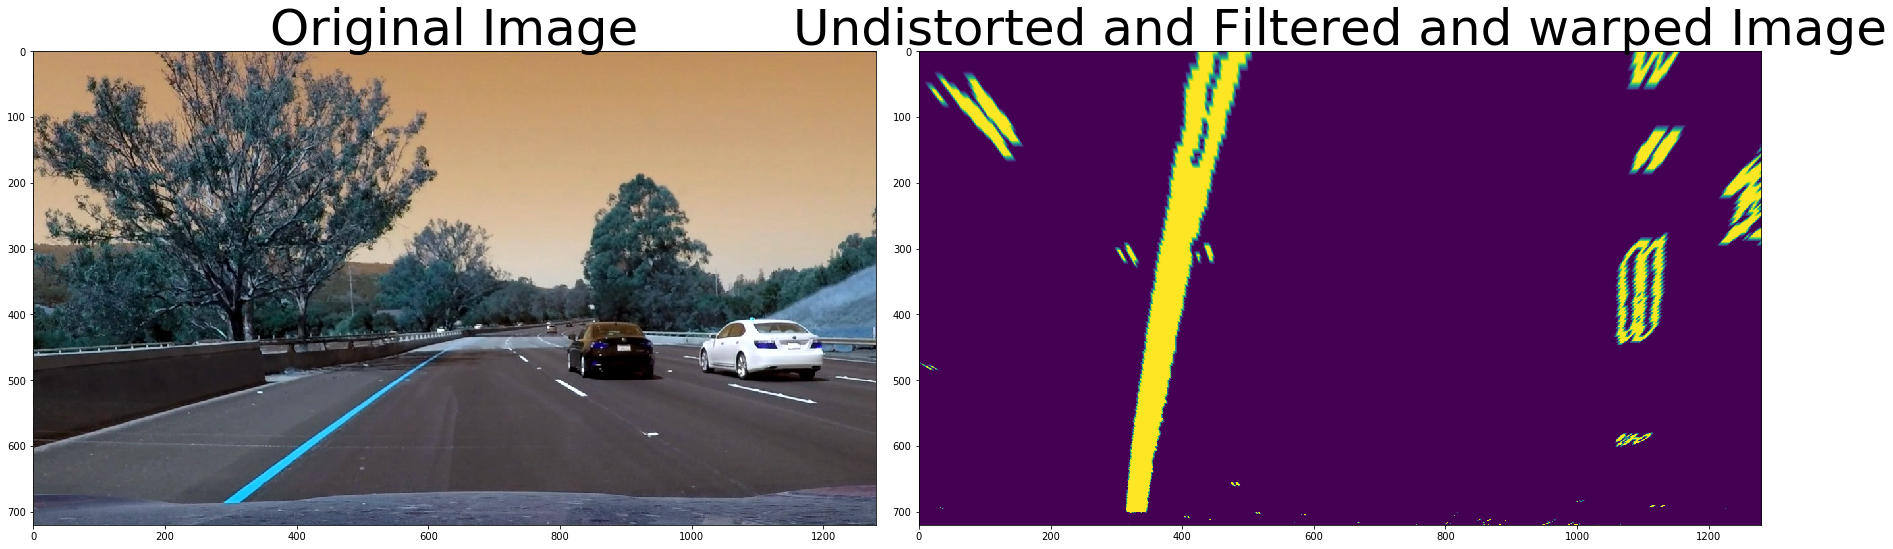

In [3]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

# remember camera matrix and distortion coefficients in the local pickle file
dist_pickle = pickle.load(open("./dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

testimages = glob.glob("./test_images/*.jpg")
#testimages = glob.glob("./clip_images/*.png")

for idx, fname in enumerate(testimages):
    img = cv2.imread(fname)
    
    img2 = cv2.undistort(img, mtx, dist,None,mtx)  
    
    #filter with combined color and gradient threshold  filters
    _, _, filtered_undistorted = color_gradient_combined(img, sobel_kernel=15, s_thresh=(170, 255), thresh=(20, 90))
    
    #write out the images for review
    write_name = "./output_images/filtered"+str(idx)+".jpg"
    #write_name = "./output_clip_images/filtered"+str(idx)+".jpg"
    cv2.imwrite(write_name, filtered_undistorted )
    
    # Now we need to semi-guess correct source and destiantion for interesitng points to use
    # the perspective transform. General idea is that we want to be in the car's vicinity
    # and not look too far ahead
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
    
    dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # calculate the reverse transform for later
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(filtered_undistorted, M, img_size)
        
    #write out the images for review
    write_name = "./output_images/warped"+str(idx)+".jpg"
    #write_name = "./output_clip_images/warped"+str(idx)+".jpg"
    cv2.imwrite(write_name, warped )
    
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Filtered and warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.show()

### At this point all warped images had well-emphasized lanes and the lanes looked parllallel cofirming the correcteness of the perspective transform

## Working with warped lines example to find the lines and then identify the curvature

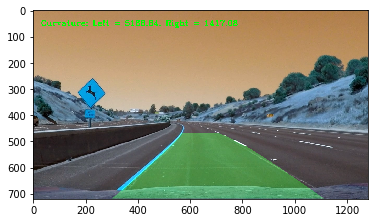

In [14]:
# Sliding winfow to find polynomials fitting lane lines (will be used on the first frame)
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    try:               
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )       
        
        if (lefty.size > 0):
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit = np.array([0,0,0])
            
        if (righty.size > 0):
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit = np.array([0,0,0])

        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        #print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img

def get_curvature(left_fit_cr, right_fit_cr):
    
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


def draw_lanes_on_image(binary_warped, orig_img, Minv, left_fitx, right_fitx, ploty, \
                        left_radius, right_radius):

    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
        
    return result


# Lets play with one image for a quick test
read_warped_image = cv2.imread("./output_images/warped3.jpg")
binary_warped = cv2.cvtColor(read_warped_image, cv2.COLOR_RGB2GRAY)
        
undistorted_image = cv2.imread("./test_images/test2.jpg") # warped3 corresponds to test2


src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
    
dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)

l, r = get_curvature(left_fit, right_fit)

result = draw_lanes_on_image(binary_warped, undistorted_image, Minv, \
                             left_fitx, right_fitx, ploty, l, r)


plt.imshow(result)
plt.show()


### the test above looks good. Looked good on all warped images.

## Lets setup the pipeline now, the process_image() method:

In [15]:
# Just so we can start running tests from this cell:

import pickle

import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


dist_pickle = pickle.load(open("./dist_pickle.p", "rb"))

mtx = dist_pickle["mtx"]

dist = dist_pickle["dist"]

src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
    
dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])

M = cv2.getPerspectiveTransform(src, dst)

Minv = cv2.getPerspectiveTransform(dst, src)

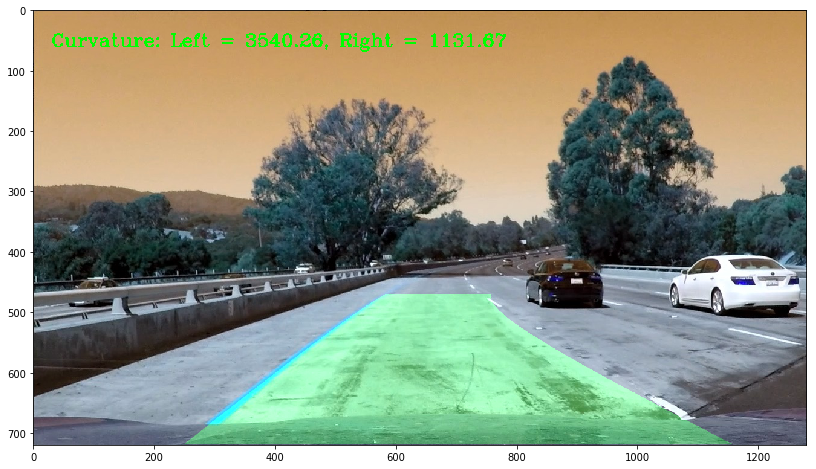

In [16]:
def process_image(image):
    
    #undistort
    img = cv2.undistort(image, mtx, dist,None,mtx)  
    
    #filter with combined color and gradient threshold  filters
    s_binary, abel_x, filtered_undistorted = color_gradient_combined(img, sobel_kernel=15, s_thresh=(170, 255), thresh=(20, 100))            

    # Warp the image using OpenCV warpPerspective()
    img_size = (img.shape[1], img.shape[0])
    binary_warped = cv2.warpPerspective(filtered_undistorted, M, img_size)
 
    left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, _ = fit_polynomial(binary_warped)

    if leftx.size > 0 and lefty.size > 0 and rightx.size > 0 and righty.size > 0:
        l, r = get_curvature(left_fit, right_fit)
    
    result = draw_lanes_on_image(binary_warped, image, Minv, left_fitx, right_fitx, ploty, l, r)
    
    return  result

# Run on a test image
test_img = cv2.imread("test_images/test1.jpg")
#test_img = cv2.imread("clip_images/frame2.png")


result = process_image(test_img)

plt.clf()
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()

## Now lets redefine process image to be more efficient and look in the vicinity of the lines from the previous frame

In [7]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


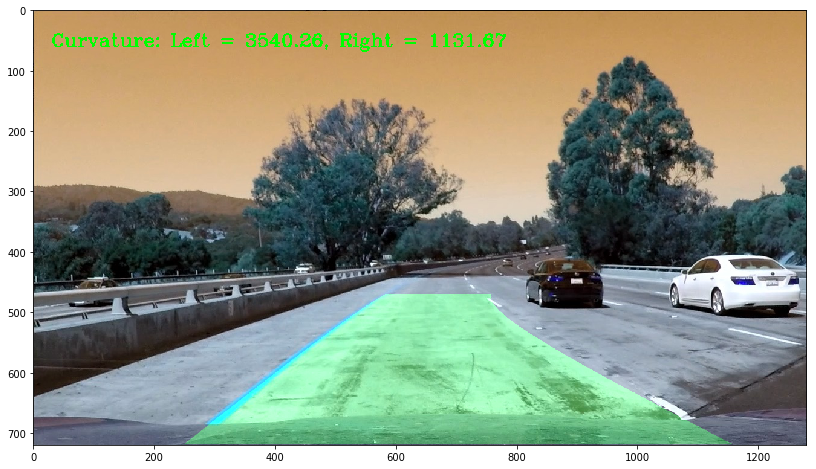

In [17]:
class Pipeline():
    
    def __init__(self):
              
        self.NEXT_LEFT_FIT = np.array([0,0,0])
        self.NEXT_RIGHT_FIT = np.array([0,0,0])
        
    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
    
        # Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
        #Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        return left_fit, right_fit, left_fitx, right_fitx, ploty

    def search_around_poly(self, binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 50

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_fit = self.NEXT_LEFT_FIT
        right_fit = self.NEXT_RIGHT_FIT
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fit, right_fit, left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
        return left_fit, right_fit, left_fitx, right_fitx, ploty

    def process_image(self, image):   
    
        #undistort
        img = cv2.undistort(image, mtx, dist,None,mtx)  
    
        #filter with combined color and gradient threshold  filters
        s_binary, abel_x, filtered_undistorted = color_gradient_combined(img, sobel_kernel=15, s_thresh=(170, 255), thresh=(20, 100))            

        # Warp the image using OpenCV warpPerspective()
        img_size = (img.shape[1], img.shape[0])
        binary_warped = cv2.warpPerspective(filtered_undistorted, M, img_size)

        # when lanes are found from scratch in each frame the algo produces better results
        # to test it just sub the next lien with the line "if True:"
        #if True:
        if (self.NEXT_LEFT_FIT[0] == 0 or self.NEXT_RIGHT_FIT[0] == 0):
            left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, _ = fit_polynomial(binary_warped)   
        else:
            left_fit, right_fit, left_fitx, right_fitx, ploty = self.search_around_poly(binary_warped) 
            
        # sanity check
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        passSanityCheck = True
        distance_between_lines = np.abs(np.average(right_fitx - left_fitx))
        if distance_between_lines * xm_per_pix < 3.7 * 0.7 or distance_between_lines * xm_per_pix > 3.7 * 1.3:
            passSanityCheck = False
        
        
        if passSanityCheck:
            self.NEXT_LEFT_FIT = left_fit
            self.NEXT_RIGHT_FIT = right_fit    
        
        l, r = get_curvature(self.NEXT_LEFT_FIT, self.NEXT_RIGHT_FIT)
    
        result = draw_lanes_on_image(binary_warped, image, Minv, left_fitx, right_fitx, ploty, l, r)
        
        return  result

# Run on a test image
test_img = cv2.imread("test_images/test1.jpg")
#test_img = cv2.imread("clip_images/frame2.png")

pipeline = Pipeline()

result = pipeline.process_image(test_img)

plt.clf()
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()

## Run the algo on the video clip:

In [18]:
pipeline = Pipeline()

video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
clip1_output = clip1.fl_image(pipeline.process_image) 
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:03<00:00, 10.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 2min 3s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [ ]:

'''
video_output = "output_images/challenge_video_output.mp4"
clip = VideoFileClip("./challenge_video.mp4").subclip(0,5)


# saving a frame at 2 second 
clip.save_frame("./clip_images/frame1.png", t = 1) 
# saving a frame at 2 second 
clip.save_frame("./clip_images/frame2.png", t = 2) 
# saving a frame at 2 second 
clip.save_frame("./clip_images/frame3.png", t = 3) 
# saving a frame at 2 second 
clip.save_frame("./clip_images/frame4.png", t = 4) 


# saving a frame at 13 second 
clip.save_frame("./clip_images/frame5.png", t = 13)
'''